# Binary Classification Model for Higgs Boson Identification Using Scikit-Learn Take 1
### David Lowe
### June 10, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The Higgs Boson Identification dataset is a binary classification situation where we are trying to predict one of the two possible outcomes.

INTRODUCTION: ATLAS is a particle physics experiment taking place at the Large Hadron Collider at CERN that searches for new particles and processes using head-on collisions of protons of extraordinarily high energy. The ATLAS experiment has recently observed a signal of the Higgs Boson decaying into two tau particles, but this decay is a small signal buried in background noise. Using simulated data with features characterizing events detected by ATLAS, the task is to classify events into "tau tau decay of a Higgs boson" versus "background."

In this Take1 iteration, we will construct and tune an XGBoost machine learning model for this dataset. We will observe the best accuracy result that we can obtain using the XGBoost model with the training and test datasets.

ANALYSIS: For this Take1 iteration, the XGBoost algorithm achieved an accuracy metric of 77.40% in training. When configured with the optimized parameters, the XGBoost algorithm processed the test dataset with an accuracy of 63.27%, which indicated a high variance issue. We will need to explore regularization techniques or other modeling approaches before deploying the model for production use.

CONCLUSION: For this iteration, the XGBoost algorithm achieved less-than-ideal results using the training and test datasets, but we should still consider using the algorithm for further modeling.

Dataset Used: Higgs Boson Identification Data Set

Dataset ML Model: Binary classification with numerical attributes

Dataset Reference: https://archive.ics.uci.edu/ml/datasets/HIGGS

One potential source of performance benchmark: https://www.kaggle.com/c/higgs-boson

The project aims to touch on the following areas:

* Document a predictive modeling problem end-to-end.
* Explore data cleaning and transformation options
* Explore non-ensemble and ensemble algorithms for baseline model performance
* Explore algorithm tuning techniques for improving model performance

Any predictive modeling machine learning project generally can be broken down into about six major tasks:

1. Prepare Environment
2. Summarize Data
3. Prepare Data
4. Model and Evaluate Algorithms
5. Improve Accuracy or Results
6. Finalize Model and Present Results

## Task 1. Prepare Environment

### 1.a) Load libraries and modules

In [0]:
# Set the random seed number for reproducible results
seedNum = 888

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
# import math
import smtplib
import requests
import gzip
import shutil
from datetime import datetime
from email.message import EmailMessage
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
# from sklearn.pipeline import Pipeline
# from sklearn.feature_selection import RFE
# from imblearn.over_sampling import SMOTE
# from imblearn.combine import SMOTEENN
# from imblearn.combine import SMOTETomek

# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import BaggingClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.ensemble import GradientBoostingClassifier
# from imblearn.ensemble import BalancedRandomForestClassifier
# from imblearn.ensemble import RUSBoostClassifier
# from imblearn.ensemble import BalancedBaggingClassifier
from xgboost import XGBClassifier

### 1.b) Set up the controlling parameters and functions

In [0]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

In [0]:
# Set up the number of CPU cores available for multi-thread processing
n_jobs = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set the flag for splitting the dataset
splitRandom = False
# splitPercentage = 0.25
splitManual = 500000

# Set the number of folds for cross validation
n_folds = 5

# Set various default modeling parameters
scoring = 'accuracy'
# scoring = 'roc_auc'

In [0]:
# Set up the email notification function
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if (sender is None) or (receiver is None) or (gateway is None) or (smtpuser is None) or (password is None):
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Python Binary Classification Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [0]:
if notifyStatus: email_notify("Library and Data Loading has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [7]:
dataset_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz'
archive_path = os.path.basename(dataset_url)
dataset_path = archive_path[:-3]
if (os.path.isfile(dataset_path) == False) :
    print('Downloading ' + dataset_url + ' as ' + archive_path)
    out_file = requests.get(dataset_url)
    open(archive_path, 'wb').write(out_file.content)
    print(archive_path, 'downloaded!')
    print('Unpacking', archive_path, '...')
    with gzip.open(archive_path, 'rb') as f_in:
        with open(dataset_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    print(archive_path, 'unpacked as', dataset_path)

colNames = ['targetVar','lepton_pt','lepton_eta','lepton_phi','miss_energy_mag','miss_energy_phi','jet_1_pt','jet_1_eta','jet_1_phi','jet_1_b_tag',
            'jet_2_pt','jet_2_eta','jet_2_phi','jet_2_b_tag','jet_3_pt','jet_3_eta','jet_3_phi','jet_3_b_tag','jet_4_pt','jet_4_eta','jet_4_phi','jet_4_b_tag',
            'm_jj','m_jjj','m_lv','m_jlv','m_bb','m_wbb','m_wwbb']
Xy_original = pd.read_csv(dataset_path, names=colNames, sep=',', header=None, index_col=False)

# Take a peek at the dataframe after import
Xy_original.head(10)

HIGGS.csv.gz downloaded!
Unpacking HIGGS.csv.gz ...
HIGGS.csv.gz unpacked as HIGGS.csv


,targetVar,lepton_pt,lepton_eta,lepton_phi,miss_energy_mag,miss_energy_phi,jet_1_pt,jet_1_eta,jet_1_phi,jet_1_b_tag,jet_2_pt,jet_2_eta,jet_2_phi,jet_2_b_tag,jet_3_pt,jet_3_eta,jet_3_phi,jet_3_b_tag,jet_4_pt,jet_4_eta,jet_4_phi,jet_4_b_tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,1.0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,1.374992,-0.653674,0.930349,1.107436,1.138904,-1.578198,-1.046985,0.000000,0.657930,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,0.812581,-0.213642,1.271015,2.214872,0.499994,-1.261432,0.732156,0.000000,0.398701,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
2,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,0.851737,1.540659,-0.819690,2.214872,0.993490,0.356080,-0.208778,2.548224,1.256955,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
3,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,2.423265,-0.676016,0.736159,2.214872,1.298720,-1.430738,-0.364658,0.000000,0.745313,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
4,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,0.800872,1.020974,0.971407,2.214872,0.596761,-0.350273,0.631194,0.000000,0.479999,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487
5,0.0,1.595839,-0.607811,0.007075,1.818450,-0.111906,0.847550,-0.566437,1.581239,2.173076,0.755421,0.643110,1.426367,0.000000,0.921661,-1.190432,-1.615589,0.000000,0.651114,-0.654227,-1.274345,3.101961,0.823761,0.938191,0.971758,0.789176,0.430553,0.961357,0.957818
6,1.0,0.409391,-1.884684,-1.027292,1.672452,-1.604598,1.338015,0.055427,0.013466,2.173076,0.509783,-1.038338,0.707862,0.000000,0.746918,-0.358465,-1.646654,0.000000,0.367058,0.069496,1.377130,3.101961,0.869418,1.222083,1.000627,0.545045,0.698653,0.977314,0.828786
7,1.0,0.933895,0.629130,0.527535,0.238033,-0.966569,0.547811,-0.059439,-1.706866,2.173076,0.941003,-2.653733,-0.157220,0.000000,1.030370,-0.175505,0.523021,2.548224,1.373547,1.291248,-1.467454,0.000000,0.901837,1.083671,0.979696,0.783300,0.849195,0.894356,0.774879
8,1.0,1.405144,0.536603,0.689554,1.179567,-0.110061,3.202405,-1.526960,-1.576033,0.000000,2.931537,0.567342,-0.130033,2.214872,1.787123,0.899499,0.585151,2.548224,0.401865,-0.151202,1.163489,0.000000,1.667071,4.039273,1.175828,1.045352,1.542972,3.534827,2.740754
9,1.0,1.176566,0.104161,1.397002,0.479721,0.265513,1.135563,1.534831,-0.253291,0.000000,1.027247,0.534316,1.180022,0.000000,2.405661,0.087557,-0.976534,2.548224,1.250383,0.268541,0.530334,0.000000,0.833175,0.773968,0.985750,1.103696,0.849140,0.937104,0.812364


In [8]:
Xy_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000000 entries, 0 to 10999999
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   targetVar        float64
 1   lepton_pt        float64
 2   lepton_eta       float64
 3   lepton_phi       float64
 4   miss_energy_mag  float64
 5   miss_energy_phi  float64
 6   jet_1_pt         float64
 7   jet_1_eta        float64
 8   jet_1_phi        float64
 9   jet_1_b_tag      float64
 10  jet_2_pt         float64
 11  jet_2_eta        float64
 12  jet_2_phi        float64
 13  jet_2_b_tag      float64
 14  jet_3_pt         float64
 15  jet_3_eta        float64
 16  jet_3_phi        float64
 17  jet_3_b_tag      float64
 18  jet_4_pt         float64
 19  jet_4_eta        float64
 20  jet_4_phi        float64
 21  jet_4_b_tag      float64
 22  m_jj             float64
 23  m_jjj            float64
 24  m_lv             float64
 25  m_jlv            float64
 26  m_bb             float64
 27  m_wbb     

In [9]:
Xy_original.describe()

,targetVar,lepton_pt,lepton_eta,lepton_phi,miss_energy_mag,miss_energy_phi,jet_1_pt,jet_1_eta,jet_1_phi,jet_1_b_tag,jet_2_pt,jet_2_eta,jet_2_phi,jet_2_b_tag,jet_3_pt,jet_3_eta,jet_3_phi,jet_3_b_tag,jet_4_pt,jet_4_eta,jet_4_phi,jet_4_b_tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
count,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07
mean,5.299203e-01,9.914658e-01,-8.297618e-06,-1.327225e-05,9.985364e-01,2.613459e-05,9.909152e-01,-2.027520e-05,7.716199e-06,9.999687e-01,9.927294e-01,-1.026444e-05,-2.076887e-05,1.000008e+00,9.922591e-01,1.459561e-05,3.678632e-06,1.000011e+00,9.861087e-01,-5.756954e-06,1.744903e-05,1.000000e+00,1.034290e+00,1.024805e+00,1.050554e+00,1.009742e+00,9.729596e-01,1.033036e+00,9.598120e-01
std,4.991040e-01,5.653777e-01,1.008827e+00,1.006346e+00,6.000185e-01,1.006326e+00,4.749747e-01,1.009303e+00,1.005901e+00,1.027808e+00,4.999939e-01,1.009331e+00,1.006154e+00,1.049398e+00,4.876623e-01,1.008747e+00,1.006305e+00,1.193676e+00,5.057777e-01,1.007694e+00,1.006366e+00,1.400209e+00,6.746354e-01,3.808074e-01,1.645763e-01,3.974453e-01,5.254063e-01,3.652556e-01,3.133378e-01
min,0.000000e+00,2.746966e-01,-2.434976e+00,-1.742508e+00,2.370088e-04,-1.743944e+00,1.375024e-01,-2.969725e+00,-1.741237e+00,0.000000e+00,1.889811e-01,-2.913090e+00,-1.742372e+00,0.000000e+00,2.636076e-01,-2.729663e+00,-1.742069e+00,0.000000e+00,3.653542e-01,-2.497265e+00,-1.742691e+00,0.000000e+00,7.507046e-02,1.986757e-01,8.304866e-02,1.320062e-01,4.786215e-02,2.951122e-01,3.307214e-01
25%,0.000000e+00,5.907533e-01,-7.383225e-01,-8.719308e-01,5.768156e-01,-8.712081e-01,6.789927e-01,-6.872450e-01,-8.680962e-01,0.000000e+00,6.564608e-01,-6.944718e-01,-8.701791e-01,0.000000e+00,6.508527e-01,-6.998083e-01,-8.711343e-01,0.000000e+00,6.177673e-01,-7.141902e-01,-8.714789e-01,0.000000e+00,7.906095e-01,8.462266e-01,9.857525e-01,7.675732e-01,6.738168e-01,8.193964e-01,7.703901e-01
50%,1.000000e+00,8.533714e-01,-5.415563e-05,-2.410638e-04,8.916277e-01,2.125454e-04,8.948193e-01,-2.543566e-05,5.813991e-05,1.086538e+00,8.901377e-01,6.027267e-05,3.514990e-04,0.000000e+00,8.972494e-01,1.728937e-04,-7.519117e-04,0.000000e+00,8.682333e-01,3.721330e-04,-2.642369e-04,0.000000e+00,8.949304e-01,9.506853e-01,9.897798e-01,9.165110e-01,8.733798e-01,9.473447e-01,8.719701e-01
75%,1.000000e+00,1.236226e+00,7.382142e-01,8.709940e-01,1.293056e+00,8.714708e-01,1.170740e+00,6.871941e-01,8.683126e-01,2.173076e+00,1.201875e+00,6.945924e-01,8.698727e-01,2.214872e+00,1.221798e+00,7.001541e-01,8.713947e-01,2.548224e+00,1.220930e+00,7.141017e-01,8.716055e-01,3.101961e+00,1.024730e+00,1.083493e+00,1.020528e+00,1.142226e+00,1.138439e+00,1.140458e+00,1.059248e+00
max,1.000000e+00,1.209891e+01,2.434868e+00,1.743236e+00,1.539682e+01,1.743257e+00,9.940391e+00,2.969674e+00,1.741454e+00,2.173076e+00,1.164708e+01,2.913210e+00,1.743175e+00,2.214872e+00,1.470899e+01,2.730009e+00,1.742884e+00,2.548224e+00,1.288257e+01,2.498009e+00,1.743372e+00,3.101961e+00,4.019237e+01,2.037278e+01,7.992739e+00,1.426244e+01,1.776285e+01,1.149652e+01,8.374498e+00


In [10]:
Xy_original.isnull().sum()

targetVar          0
lepton_pt          0
lepton_eta         0
lepton_phi         0
miss_energy_mag    0
miss_energy_phi    0
jet_1_pt           0
jet_1_eta          0
jet_1_phi          0
jet_1_b_tag        0
jet_2_pt           0
jet_2_eta          0
jet_2_phi          0
jet_2_b_tag        0
jet_3_pt           0
jet_3_eta          0
jet_3_phi          0
jet_3_b_tag        0
jet_4_pt           0
jet_4_eta          0
jet_4_phi          0
jet_4_b_tag        0
m_jj               0
m_jjj              0
m_lv               0
m_jlv              0
m_bb               0
m_wbb              0
m_wwbb             0
dtype: int64

In [11]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  0


### 1.d) Data Cleaning

In [12]:
# Convert columns from one data type to another
Xy_original['targetVar'] = Xy_original['targetVar'].astype('int')

# Take a peek at the dataframe after cleaning
Xy_original.head(10)

,targetVar,lepton_pt,lepton_eta,lepton_phi,miss_energy_mag,miss_energy_phi,jet_1_pt,jet_1_eta,jet_1_phi,jet_1_b_tag,jet_2_pt,jet_2_eta,jet_2_phi,jet_2_b_tag,jet_3_pt,jet_3_eta,jet_3_phi,jet_3_b_tag,jet_4_pt,jet_4_eta,jet_4_phi,jet_4_b_tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,1,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,1.374992,-0.653674,0.930349,1.107436,1.138904,-1.578198,-1.046985,0.000000,0.657930,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,1,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,0.812581,-0.213642,1.271015,2.214872,0.499994,-1.261432,0.732156,0.000000,0.398701,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
2,1,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,0.851737,1.540659,-0.819690,2.214872,0.993490,0.356080,-0.208778,2.548224,1.256955,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
3,0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,2.423265,-0.676016,0.736159,2.214872,1.298720,-1.430738,-0.364658,0.000000,0.745313,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
4,1,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,0.800872,1.020974,0.971407,2.214872,0.596761,-0.350273,0.631194,0.000000,0.479999,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487
5,0,1.595839,-0.607811,0.007075,1.818450,-0.111906,0.847550,-0.566437,1.581239,2.173076,0.755421,0.643110,1.426367,0.000000,0.921661,-1.190432,-1.615589,0.000000,0.651114,-0.654227,-1.274345,3.101961,0.823761,0.938191,0.971758,0.789176,0.430553,0.961357,0.957818
6,1,0.409391,-1.884684,-1.027292,1.672452,-1.604598,1.338015,0.055427,0.013466,2.173076,0.509783,-1.038338,0.707862,0.000000,0.746918,-0.358465,-1.646654,0.000000,0.367058,0.069496,1.377130,3.101961,0.869418,1.222083,1.000627,0.545045,0.698653,0.977314,0.828786
7,1,0.933895,0.629130,0.527535,0.238033,-0.966569,0.547811,-0.059439,-1.706866,2.173076,0.941003,-2.653733,-0.157220,0.000000,1.030370,-0.175505,0.523021,2.548224,1.373547,1.291248,-1.467454,0.000000,0.901837,1.083671,0.979696,0.783300,0.849195,0.894356,0.774879
8,1,1.405144,0.536603,0.689554,1.179567,-0.110061,3.202405,-1.526960,-1.576033,0.000000,2.931537,0.567342,-0.130033,2.214872,1.787123,0.899499,0.585151,2.548224,0.401865,-0.151202,1.163489,0.000000,1.667071,4.039273,1.175828,1.045352,1.542972,3.534827,2.740754
9,1,1.176566,0.104161,1.397002,0.479721,0.265513,1.135563,1.534831,-0.253291,0.000000,1.027247,0.534316,1.180022,0.000000,2.405661,0.087557,-0.976534,2.548224,1.250383,0.268541,0.530334,0.000000,0.833175,0.773968,0.985750,1.103696,0.849140,0.937104,0.812364


In [13]:
Xy_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000000 entries, 0 to 10999999
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   targetVar        int64  
 1   lepton_pt        float64
 2   lepton_eta       float64
 3   lepton_phi       float64
 4   miss_energy_mag  float64
 5   miss_energy_phi  float64
 6   jet_1_pt         float64
 7   jet_1_eta        float64
 8   jet_1_phi        float64
 9   jet_1_b_tag      float64
 10  jet_2_pt         float64
 11  jet_2_eta        float64
 12  jet_2_phi        float64
 13  jet_2_b_tag      float64
 14  jet_3_pt         float64
 15  jet_3_eta        float64
 16  jet_3_phi        float64
 17  jet_3_b_tag      float64
 18  jet_4_pt         float64
 19  jet_4_eta        float64
 20  jet_4_phi        float64
 21  jet_4_b_tag      float64
 22  m_jj             float64
 23  m_jjj            float64
 24  m_lv             float64
 25  m_jlv            float64
 26  m_bb             float64
 27  m_wbb     

In [14]:
Xy_original.describe()

,targetVar,lepton_pt,lepton_eta,lepton_phi,miss_energy_mag,miss_energy_phi,jet_1_pt,jet_1_eta,jet_1_phi,jet_1_b_tag,jet_2_pt,jet_2_eta,jet_2_phi,jet_2_b_tag,jet_3_pt,jet_3_eta,jet_3_phi,jet_3_b_tag,jet_4_pt,jet_4_eta,jet_4_phi,jet_4_b_tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
count,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07
mean,5.299203e-01,9.914658e-01,-8.297618e-06,-1.327225e-05,9.985364e-01,2.613459e-05,9.909152e-01,-2.027520e-05,7.716199e-06,9.999687e-01,9.927294e-01,-1.026444e-05,-2.076887e-05,1.000008e+00,9.922591e-01,1.459561e-05,3.678632e-06,1.000011e+00,9.861087e-01,-5.756954e-06,1.744903e-05,1.000000e+00,1.034290e+00,1.024805e+00,1.050554e+00,1.009742e+00,9.729596e-01,1.033036e+00,9.598120e-01
std,4.991040e-01,5.653777e-01,1.008827e+00,1.006346e+00,6.000185e-01,1.006326e+00,4.749747e-01,1.009303e+00,1.005901e+00,1.027808e+00,4.999939e-01,1.009331e+00,1.006154e+00,1.049398e+00,4.876623e-01,1.008747e+00,1.006305e+00,1.193676e+00,5.057777e-01,1.007694e+00,1.006366e+00,1.400209e+00,6.746354e-01,3.808074e-01,1.645763e-01,3.974453e-01,5.254063e-01,3.652556e-01,3.133378e-01
min,0.000000e+00,2.746966e-01,-2.434976e+00,-1.742508e+00,2.370088e-04,-1.743944e+00,1.375024e-01,-2.969725e+00,-1.741237e+00,0.000000e+00,1.889811e-01,-2.913090e+00,-1.742372e+00,0.000000e+00,2.636076e-01,-2.729663e+00,-1.742069e+00,0.000000e+00,3.653542e-01,-2.497265e+00,-1.742691e+00,0.000000e+00,7.507046e-02,1.986757e-01,8.304866e-02,1.320062e-01,4.786215e-02,2.951122e-01,3.307214e-01
25%,0.000000e+00,5.907533e-01,-7.383225e-01,-8.719308e-01,5.768156e-01,-8.712081e-01,6.789927e-01,-6.872450e-01,-8.680962e-01,0.000000e+00,6.564608e-01,-6.944718e-01,-8.701791e-01,0.000000e+00,6.508527e-01,-6.998083e-01,-8.711343e-01,0.000000e+00,6.177673e-01,-7.141902e-01,-8.714789e-01,0.000000e+00,7.906095e-01,8.462266e-01,9.857525e-01,7.675732e-01,6.738168e-01,8.193964e-01,7.703901e-01
50%,1.000000e+00,8.533714e-01,-5.415563e-05,-2.410638e-04,8.916277e-01,2.125454e-04,8.948193e-01,-2.543566e-05,5.813991e-05,1.086538e+00,8.901377e-01,6.027267e-05,3.514990e-04,0.000000e+00,8.972494e-01,1.728937e-04,-7.519117e-04,0.000000e+00,8.682333e-01,3.721330e-04,-2.642369e-04,0.000000e+00,8.949304e-01,9.506853e-01,9.897798e-01,9.165110e-01,8.733798e-01,9.473447e-01,8.719701e-01
75%,1.000000e+00,1.236226e+00,7.382142e-01,8.709940e-01,1.293056e+00,8.714708e-01,1.170740e+00,6.871941e-01,8.683126e-01,2.173076e+00,1.201875e+00,6.945924e-01,8.698727e-01,2.214872e+00,1.221798e+00,7.001541e-01,8.713947e-01,2.548224e+00,1.220930e+00,7.141017e-01,8.716055e-01,3.101961e+00,1.024730e+00,1.083493e+00,1.020528e+00,1.142226e+00,1.138439e+00,1.140458e+00,1.059248e+00
max,1.000000e+00,1.209891e+01,2.434868e+00,1.743236e+00,1.539682e+01,1.743257e+00,9.940391e+00,2.969674e+00,1.741454e+00,2.173076e+00,1.164708e+01,2.913210e+00,1.743175e+00,2.214872e+00,1.470899e+01,2.730009e+00,1.742884e+00,2.548224e+00,1.288257e+01,2.498009e+00,1.743372e+00,3.101961e+00,4.019237e+01,2.037278e+01,7.992739e+00,1.426244e+01,1.776285e+01,1.149652e+01,8.374498e+00


In [15]:
Xy_original.isnull().sum()

targetVar          0
lepton_pt          0
lepton_eta         0
lepton_phi         0
miss_energy_mag    0
miss_energy_phi    0
jet_1_pt           0
jet_1_eta          0
jet_1_phi          0
jet_1_b_tag        0
jet_2_pt           0
jet_2_eta          0
jet_2_phi          0
jet_2_b_tag        0
jet_3_pt           0
jet_3_eta          0
jet_3_phi          0
jet_3_b_tag        0
jet_4_pt           0
jet_4_eta          0
jet_4_phi          0
jet_4_b_tag        0
m_jj               0
m_jjj              0
m_lv               0
m_jlv              0
m_bb               0
m_wbb              0
m_wwbb             0
dtype: int64

In [16]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  0


### 1.e) Splitting Data into Attribute-only and Target-only Sets

In [0]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = 1

In [18]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (11000000, 29) X_original.shape: (11000000, 28) y_original.shape: (11000000,)


### 1.f) Set up the parameters for data visualization

In [0]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

In [0]:
if notifyStatus: email_notify("Library and Data Loading completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2. Summarize Data

In [0]:
if notifyStatus: email_notify("Data Summarization and Visualization has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Descriptive Statistics

#### 2.a.i) Peek at the attribute columns

In [22]:
X_original.head(10)

,lepton_pt,lepton_eta,lepton_phi,miss_energy_mag,miss_energy_phi,jet_1_pt,jet_1_eta,jet_1_phi,jet_1_b_tag,jet_2_pt,jet_2_eta,jet_2_phi,jet_2_b_tag,jet_3_pt,jet_3_eta,jet_3_phi,jet_3_b_tag,jet_4_pt,jet_4_eta,jet_4_phi,jet_4_b_tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,1.374992,-0.653674,0.930349,1.107436,1.138904,-1.578198,-1.046985,0.000000,0.657930,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,0.812581,-0.213642,1.271015,2.214872,0.499994,-1.261432,0.732156,0.000000,0.398701,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
2,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,0.851737,1.540659,-0.819690,2.214872,0.993490,0.356080,-0.208778,2.548224,1.256955,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
3,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,2.423265,-0.676016,0.736159,2.214872,1.298720,-1.430738,-0.364658,0.000000,0.745313,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
4,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,0.800872,1.020974,0.971407,2.214872,0.596761,-0.350273,0.631194,0.000000,0.479999,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487
5,1.595839,-0.607811,0.007075,1.818450,-0.111906,0.847550,-0.566437,1.581239,2.173076,0.755421,0.643110,1.426367,0.000000,0.921661,-1.190432,-1.615589,0.000000,0.651114,-0.654227,-1.274345,3.101961,0.823761,0.938191,0.971758,0.789176,0.430553,0.961357,0.957818
6,0.409391,-1.884684,-1.027292,1.672452,-1.604598,1.338015,0.055427,0.013466,2.173076,0.509783,-1.038338,0.707862,0.000000,0.746918,-0.358465,-1.646654,0.000000,0.367058,0.069496,1.377130,3.101961,0.869418,1.222083,1.000627,0.545045,0.698653,0.977314,0.828786
7,0.933895,0.629130,0.527535,0.238033,-0.966569,0.547811,-0.059439,-1.706866,2.173076,0.941003,-2.653733,-0.157220,0.000000,1.030370,-0.175505,0.523021,2.548224,1.373547,1.291248,-1.467454,0.000000,0.901837,1.083671,0.979696,0.783300,0.849195,0.894356,0.774879
8,1.405144,0.536603,0.689554,1.179567,-0.110061,3.202405,-1.526960,-1.576033,0.000000,2.931537,0.567342,-0.130033,2.214872,1.787123,0.899499,0.585151,2.548224,0.401865,-0.151202,1.163489,0.000000,1.667071,4.039273,1.175828,1.045352,1.542972,3.534827,2.740754
9,1.176566,0.104161,1.397002,0.479721,0.265513,1.135563,1.534831,-0.253291,0.000000,1.027247,0.534316,1.180022,0.000000,2.405661,0.087557,-0.976534,2.548224,1.250383,0.268541,0.530334,0.000000,0.833175,0.773968,0.985750,1.103696,0.849140,0.937104,0.812364


#### 2.a.ii) Dimensions and attribute types

In [23]:
X_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000000 entries, 0 to 10999999
Data columns (total 28 columns):
 #   Column           Dtype  
---  ------           -----  
 0   lepton_pt        float64
 1   lepton_eta       float64
 2   lepton_phi       float64
 3   miss_energy_mag  float64
 4   miss_energy_phi  float64
 5   jet_1_pt         float64
 6   jet_1_eta        float64
 7   jet_1_phi        float64
 8   jet_1_b_tag      float64
 9   jet_2_pt         float64
 10  jet_2_eta        float64
 11  jet_2_phi        float64
 12  jet_2_b_tag      float64
 13  jet_3_pt         float64
 14  jet_3_eta        float64
 15  jet_3_phi        float64
 16  jet_3_b_tag      float64
 17  jet_4_pt         float64
 18  jet_4_eta        float64
 19  jet_4_phi        float64
 20  jet_4_b_tag      float64
 21  m_jj             float64
 22  m_jjj            float64
 23  m_lv             float64
 24  m_jlv            float64
 25  m_bb             float64
 26  m_wbb            float64
 27  m_wwbb    

#### 2.a.iii) Statistical summary of the attributes

In [24]:
X_original.describe()

,lepton_pt,lepton_eta,lepton_phi,miss_energy_mag,miss_energy_phi,jet_1_pt,jet_1_eta,jet_1_phi,jet_1_b_tag,jet_2_pt,jet_2_eta,jet_2_phi,jet_2_b_tag,jet_3_pt,jet_3_eta,jet_3_phi,jet_3_b_tag,jet_4_pt,jet_4_eta,jet_4_phi,jet_4_b_tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
count,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07,1.100000e+07
mean,9.914658e-01,-8.297618e-06,-1.327225e-05,9.985364e-01,2.613459e-05,9.909152e-01,-2.027520e-05,7.716199e-06,9.999687e-01,9.927294e-01,-1.026444e-05,-2.076887e-05,1.000008e+00,9.922591e-01,1.459561e-05,3.678632e-06,1.000011e+00,9.861087e-01,-5.756954e-06,1.744903e-05,1.000000e+00,1.034290e+00,1.024805e+00,1.050554e+00,1.009742e+00,9.729596e-01,1.033036e+00,9.598120e-01
std,5.653777e-01,1.008827e+00,1.006346e+00,6.000185e-01,1.006326e+00,4.749747e-01,1.009303e+00,1.005901e+00,1.027808e+00,4.999939e-01,1.009331e+00,1.006154e+00,1.049398e+00,4.876623e-01,1.008747e+00,1.006305e+00,1.193676e+00,5.057777e-01,1.007694e+00,1.006366e+00,1.400209e+00,6.746354e-01,3.808074e-01,1.645763e-01,3.974453e-01,5.254063e-01,3.652556e-01,3.133378e-01
min,2.746966e-01,-2.434976e+00,-1.742508e+00,2.370088e-04,-1.743944e+00,1.375024e-01,-2.969725e+00,-1.741237e+00,0.000000e+00,1.889811e-01,-2.913090e+00,-1.742372e+00,0.000000e+00,2.636076e-01,-2.729663e+00,-1.742069e+00,0.000000e+00,3.653542e-01,-2.497265e+00,-1.742691e+00,0.000000e+00,7.507046e-02,1.986757e-01,8.304866e-02,1.320062e-01,4.786215e-02,2.951122e-01,3.307214e-01
25%,5.907533e-01,-7.383225e-01,-8.719308e-01,5.768156e-01,-8.712081e-01,6.789927e-01,-6.872450e-01,-8.680962e-01,0.000000e+00,6.564608e-01,-6.944718e-01,-8.701791e-01,0.000000e+00,6.508527e-01,-6.998083e-01,-8.711343e-01,0.000000e+00,6.177673e-01,-7.141902e-01,-8.714789e-01,0.000000e+00,7.906095e-01,8.462266e-01,9.857525e-01,7.675732e-01,6.738168e-01,8.193964e-01,7.703901e-01
50%,8.533714e-01,-5.415563e-05,-2.410638e-04,8.916277e-01,2.125454e-04,8.948193e-01,-2.543566e-05,5.813991e-05,1.086538e+00,8.901377e-01,6.027267e-05,3.514990e-04,0.000000e+00,8.972494e-01,1.728937e-04,-7.519117e-04,0.000000e+00,8.682333e-01,3.721330e-04,-2.642369e-04,0.000000e+00,8.949304e-01,9.506853e-01,9.897798e-01,9.165110e-01,8.733798e-01,9.473447e-01,8.719701e-01
75%,1.236226e+00,7.382142e-01,8.709940e-01,1.293056e+00,8.714708e-01,1.170740e+00,6.871941e-01,8.683126e-01,2.173076e+00,1.201875e+00,6.945924e-01,8.698727e-01,2.214872e+00,1.221798e+00,7.001541e-01,8.713947e-01,2.548224e+00,1.220930e+00,7.141017e-01,8.716055e-01,3.101961e+00,1.024730e+00,1.083493e+00,1.020528e+00,1.142226e+00,1.138439e+00,1.140458e+00,1.059248e+00
max,1.209891e+01,2.434868e+00,1.743236e+00,1.539682e+01,1.743257e+00,9.940391e+00,2.969674e+00,1.741454e+00,2.173076e+00,1.164708e+01,2.913210e+00,1.743175e+00,2.214872e+00,1.470899e+01,2.730009e+00,1.742884e+00,2.548224e+00,1.288257e+01,2.498009e+00,1.743372e+00,3.101961e+00,4.019237e+01,2.037278e+01,7.992739e+00,1.426244e+01,1.776285e+01,1.149652e+01,8.374498e+00


#### 2.a.iv) Summarize the levels of the class attribute

In [25]:
Xy_original.groupby('targetVar').size()

targetVar
0    5170877
1    5829123
dtype: int64

### 2.b) Data Visualization

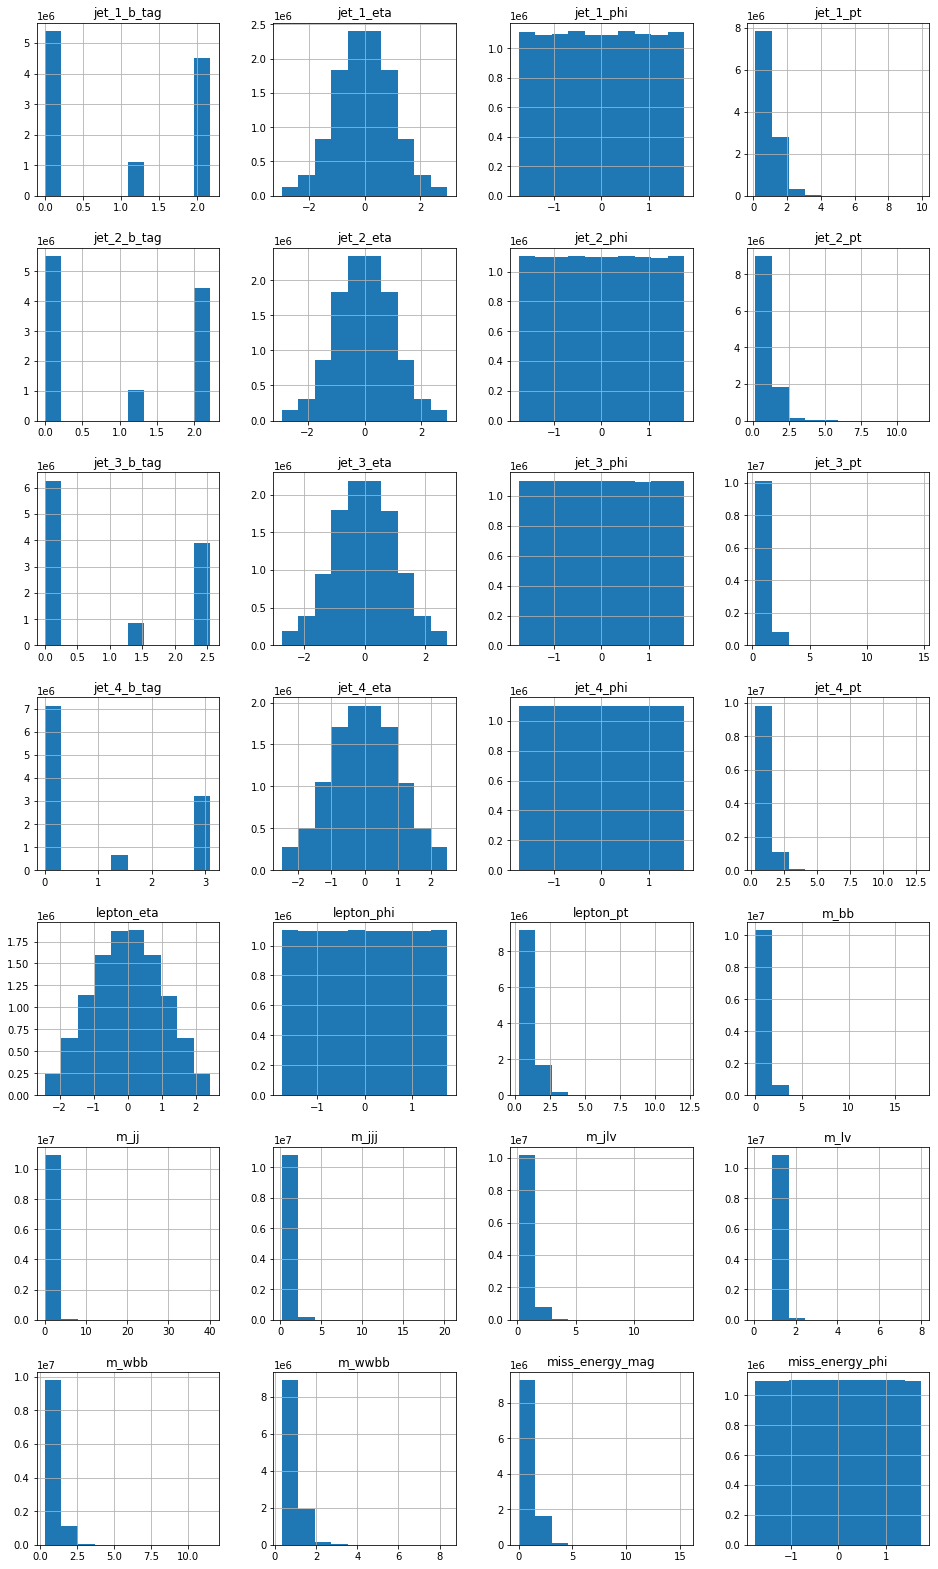

In [26]:
# Histograms for each attribute
X_original.hist(layout=(dispRow,dispCol))
plt.show()

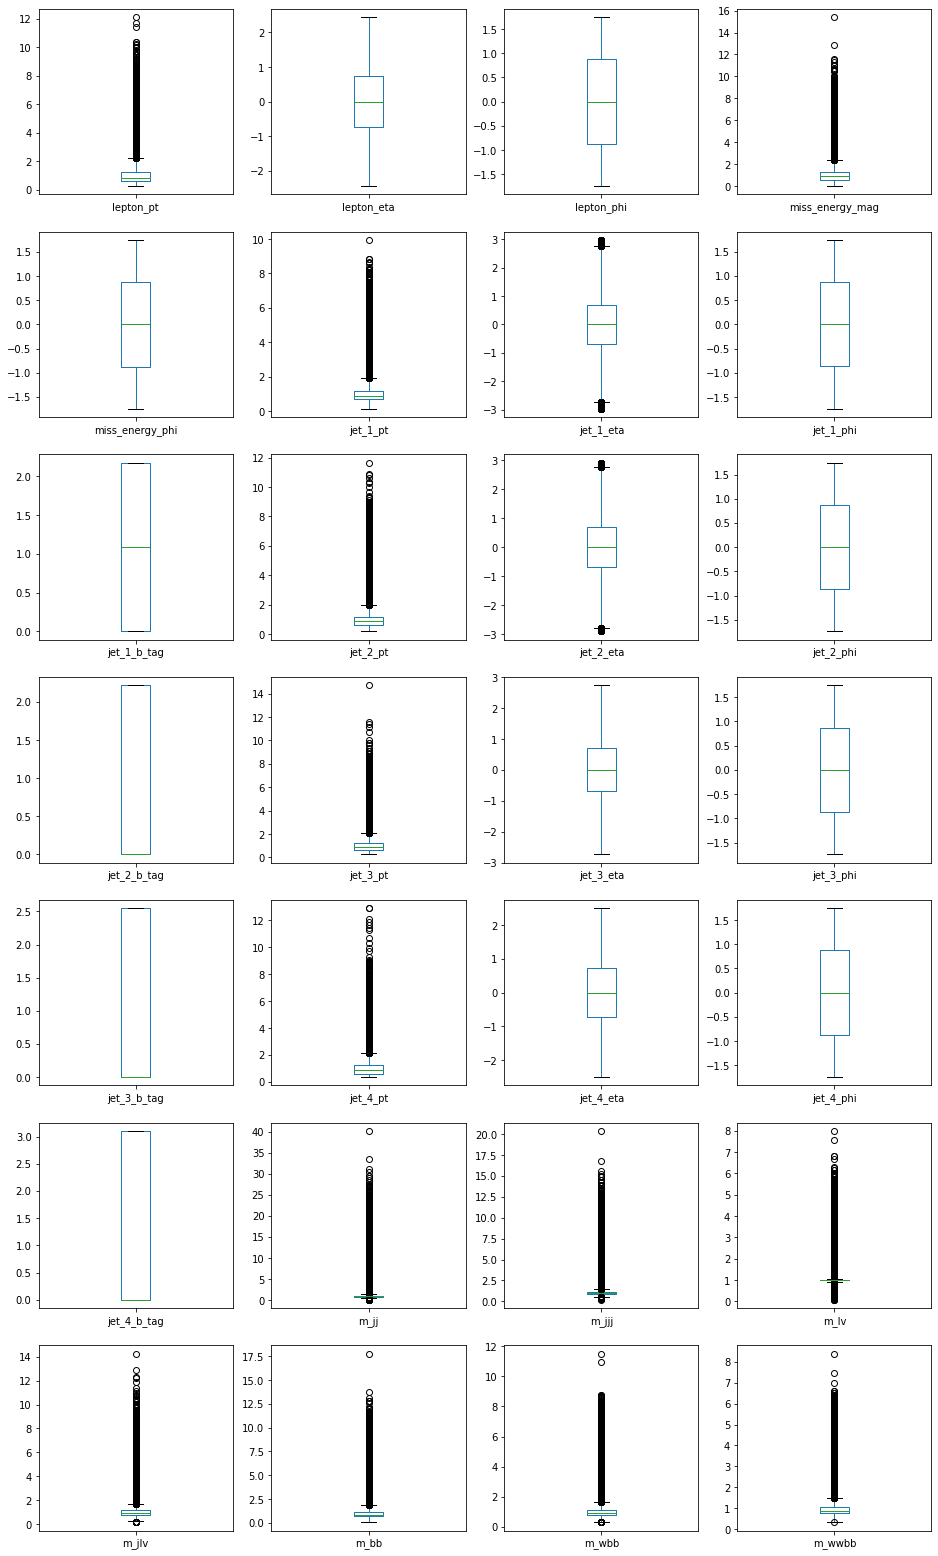

In [27]:
# Box and Whisker plot for each attribute
X_original.plot(kind='box', subplots=True, layout=(dispRow,dispCol))
plt.show()

In [0]:
# Correlation matrix
# fig = plt.figure(figsize=(16,12))
# ax = fig.add_subplot(111)
# correlations = X_original.corr(method='pearson')
# cax = ax.matshow(correlations, vmin=-1, vmax=1)
# fig.colorbar(cax)
# plt.show()

In [0]:
if notifyStatus: email_notify("Data Summarization and Visualization completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3. Prepare Data

In [0]:
if notifyStatus: email_notify("Data Cleaning and Transformation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Splitting Data into Training and Test Sets

In [0]:
# Not applicable for this iteration of the project
# Perform one-hot-encoding on the categorical attributes
# X_original = pd.get_dummies(X_original)
# print(X_original.info())

In [32]:
# Split the data further into training and test datasets
if splitRandom:
    X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_original, y_original, test_size=splitPercentage, 
                                                                    stratify=y_original, random_state=seedNum)
else:
    train_size = len(X_original) - splitManual
    X_train_df = X_original.copy()
    X_train_df = X_train_df.iloc[0:train_size,:]
    y_train_df = y_original.copy()
    y_train_df = y_train_df.iloc[0:train_size]
    X_test_df = X_original.copy()
    X_test_df = X_test_df.iloc[train_size:,:]
    y_test_df = y_original.copy()
    y_test_df = y_test_df.iloc[train_size:]
print("X_train_df.shape: {} y_train_df.shape: {}".format(X_train_df.shape, y_train_df.shape))
print("X_test_df.shape: {} y_test_df.shape: {}".format(X_test_df.shape, y_test_df.shape))

X_train_df.shape: (10500000, 28) y_train_df.shape: (10500000,)
X_test_df.shape: (500000, 28) y_test_df.shape: (500000,)


### 3.b) Feature Scaling and Data Pre-Processing

In [33]:
# Apply feature scaling to the training attributes
columns_to_scale = X_train_df.columns.tolist()
autoscaler = preprocessing.MinMaxScaler()
print('Performing Min-Max scaling on the features:', columns_to_scale)
values_to_scale = X_train_df[columns_to_scale].to_numpy(copy=True)
X_train_df[columns_to_scale] = autoscaler.fit_transform(values_to_scale)

print(X_train_df.head(-10))

Performing Min-Max scaling on the features: ['lepton_pt', 'lepton_eta', 'lepton_phi', 'miss_energy_mag', 'miss_energy_phi', 'jet_1_pt', 'jet_1_eta', 'jet_1_phi', 'jet_1_b_tag', 'jet_2_pt', 'jet_2_eta', 'jet_2_phi', 'jet_2_b_tag', 'jet_3_pt', 'jet_3_eta', 'jet_3_phi', 'jet_3_b_tag', 'jet_4_pt', 'jet_4_eta', 'jet_4_phi', 'jet_4_b_tag', 'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']
          lepton_pt  lepton_eta  lepton_phi  ...      m_bb     m_wbb    m_wwbb
0          0.050286      0.3696    0.564642  ...  0.038035  0.061924  0.067873
1          0.053521      0.5676    0.603005  ...  0.041314  0.062246  0.058135
2          0.044328      0.8020    0.030563  ...  0.042641  0.050959  0.055869
3          0.090466      0.3200    0.768393  ...  0.046364  0.065315  0.077971
4          0.070221      0.5660    0.936646  ...  0.061272  0.051523  0.059396
...             ...         ...         ...  ...       ...       ...       ...
10499985   0.049590      0.6672    0.453028  ...  

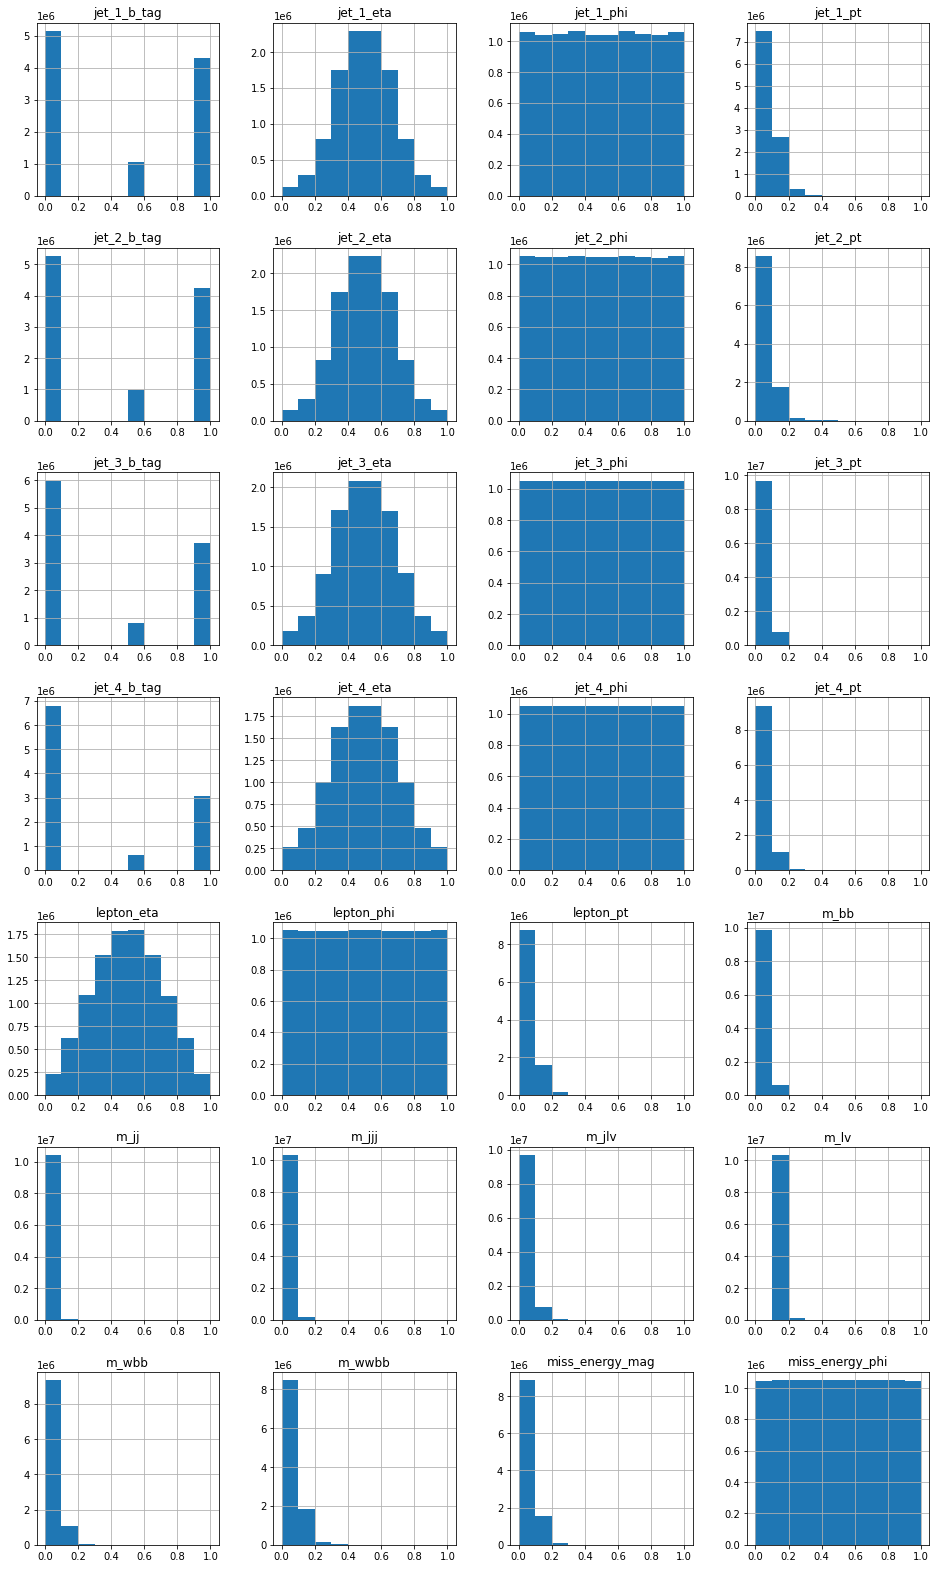

In [34]:
# Histograms for each attribute
X_train_df.hist(layout=(dispRow,dispCol))
plt.show()

In [35]:
# Apply the same feature scaling to the testing attributes
print('Performing Min-Max scaling on the features:', columns_to_scale)
values_to_scale = X_test_df[columns_to_scale].to_numpy(copy=True)
X_test_df[columns_to_scale] = autoscaler.fit_transform(values_to_scale)

print(X_test_df.head(-10))

Performing Min-Max scaling on the features: ['lepton_pt', 'lepton_eta', 'lepton_phi', 'miss_energy_mag', 'miss_energy_phi', 'jet_1_pt', 'jet_1_eta', 'jet_1_phi', 'jet_1_b_tag', 'jet_2_pt', 'jet_2_eta', 'jet_2_phi', 'jet_2_b_tag', 'jet_3_pt', 'jet_3_eta', 'jet_3_phi', 'jet_3_b_tag', 'jet_4_pt', 'jet_4_eta', 'jet_4_phi', 'jet_4_b_tag', 'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']
          lepton_pt  lepton_eta  lepton_phi  ...      m_bb     m_wbb    m_wwbb
10500000   0.201279      0.4582    0.805163  ...  0.081572  0.085913  0.110858
10500001   0.019667      0.0702    0.320907  ...  0.045093  0.086890  0.108800
10500002   0.003958      0.2048    0.705676  ...  0.072909  0.111925  0.117394
10500003   0.068358      0.5188    0.090892  ...  0.089235  0.054386  0.078836
10500004   0.044652      0.4348    0.913247  ...  0.036418  0.085642  0.079791
...             ...         ...         ...  ...       ...       ...       ...
10999985   0.048041      0.6760    0.916749  ...  

### 3.c) Training Data Balancing

In [0]:
# Not applicable for this iteration of the project

### 3.d) Feature Selection

In [0]:
# Not applicable for this iteration of the project

### 3.e) Display the Final Datasets for Model-Building

In [38]:
# Finalize the training and testing datasets for the modeling activities
X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()
X_test = X_test_df.to_numpy()
y_test = y_test_df.to_numpy()
print("X_train.shape: {} y_train.shape: {}".format(X_train.shape, y_train.shape))
print("X_test.shape: {} y_test.shape: {}".format(X_test.shape, y_test.shape))

X_train.shape: (10500000, 28) y_train.shape: (10500000,)
X_test.shape: (500000, 28) y_test.shape: (500000,)


In [0]:
if notifyStatus: email_notify("Data Cleaning and Transformation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4. Model and Evaluate Algorithms

### 4.a) Set test options and evaluation metric

In [0]:
# Set up Algorithms Spot-Checking Array
startTimeModule = datetime.now()
train_models = []
train_results = []
train_model_names = []
train_metrics = []
# train_models.append(('LGR', LogisticRegression(random_state=seedNum)))
# train_models.append(('CART', DecisionTreeClassifier(random_state=seedNum)))
# train_models.append(('KNN', KNeighborsClassifier(n_jobs=n_jobs)))
# train_models.append(('BGT', BaggingClassifier(random_state=seedNum, n_jobs=n_jobs)))
# train_models.append(('RNF', RandomForestClassifier(random_state=seedNum, n_jobs=n_jobs)))
# train_models.append(('EXT', ExtraTreesClassifier(random_state=seedNum, n_jobs=n_jobs)))
# train_models.append(('GBM', GradientBoostingClassifier(random_state=seedNum)))
train_models.append(('XGB', XGBClassifier(random_state=seedNum, n_jobs=n_jobs, objective='binary:logistic', tree_method='gpu_hist')))

In [41]:
# Generate model in turn
for name, model in train_models:
	if notifyStatus: email_notify("Algorithm "+name+" modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	startTimeModule = datetime.now()
	kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=n_jobs, verbose=1)
	train_results.append(cv_results)
	train_model_names.append(name)
	train_metrics.append(cv_results.mean())
	print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
	print(model)
	print ('Model training time:', (datetime.now() - startTimeModule), '\n')
	if notifyStatus: email_notify("Algorithm "+name+" modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics ('+scoring+') from all models:',np.mean(train_metrics))
print ('Total training time for all models:',(datetime.now() - startTimeModule))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


XGB: 0.713599 (0.000204)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=888,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)
Model training time: 0:01:01.354729 

Average metrics (accuracy) from all models: 0.7135990476190477
Total training time for all models: 0:01:01.355190


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.0min finished


### 4.b) Spot-checking baseline algorithms

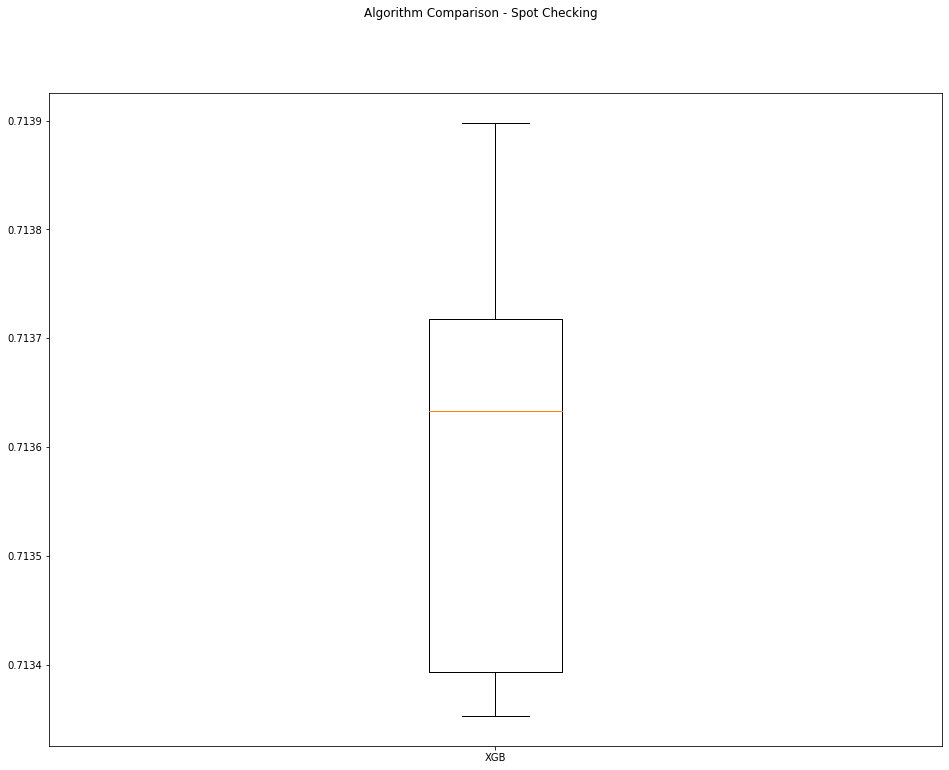

In [42]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
plt.boxplot(train_results)
ax.set_xticklabels(train_model_names)
plt.show()

## Task 5. Improve Accuracy

### 5.a) Algorithm Tuning

In [0]:
# Set up the comparison array
tune_results = []
tune_model_names = []

In [44]:
# Tuning XGBoost n_estimators, max_depth, and min_child_weight
startTimeModule = datetime.now()
if notifyStatus: email_notify("Algorithm tuning iteration #1 has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model1 = XGBClassifier(random_state=seedNum, n_jobs=n_jobs, objective='binary:logistic', tree_method='gpu_hist')
tune_model_names.append('XGB_1')
paramGrid1 = dict(n_estimators=range(1000,2001,100), max_depth=np.array([6,9,12]))

kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=scoring, cv=kfold, n_jobs=n_jobs, verbose=2)
grid_result1 = grid1.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
if notifyStatus: email_notify("Algorithm tuning iteration #1 completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 33 candidates, totalling 165 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] max_depth=6, n_estimators=1000 ..................................
[CV] ................... max_depth=6, n_estimators=1000, total= 1.4min
[CV] max_depth=6, n_estimators=1000 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min remaining:    0.0s


[CV] ................... max_depth=6, n_estimators=1000, total= 1.4min
[CV] max_depth=6, n_estimators=1000 ..................................
[CV] ................... max_depth=6, n_estimators=1000, total= 1.5min
[CV] max_depth=6, n_estimators=1000 ..................................
[CV] ................... max_depth=6, n_estimators=1000, total= 1.4min
[CV] max_depth=6, n_estimators=1000 ..................................
[CV] ................... max_depth=6, n_estimators=1000, total= 1.4min
[CV] max_depth=6, n_estimators=1100 ..................................
[CV] ................... max_depth=6, n_estimators=1100, total= 1.6min
[CV] max_depth=6, n_estimators=1100 ..................................
[CV] ................... max_depth=6, n_estimators=1100, total= 1.6min
[CV] max_depth=6, n_estimators=1100 ..................................
[CV] ................... max_depth=6, n_estimators=1100, total= 1.6min
[CV] max_depth=6, n_estimators=1100 ..................................
[CV] .

[Parallel(n_jobs=1)]: Done 165 out of 165 | elapsed: 651.3min finished


Best: 0.774030 using {'max_depth': 12, 'n_estimators': 2000}
0.753906 (0.000168) with: {'max_depth': 6, 'n_estimators': 1000}
0.754529 (0.000173) with: {'max_depth': 6, 'n_estimators': 1100}
0.755325 (0.000188) with: {'max_depth': 6, 'n_estimators': 1200}
0.755988 (0.000145) with: {'max_depth': 6, 'n_estimators': 1300}
0.756636 (0.000193) with: {'max_depth': 6, 'n_estimators': 1400}
0.757207 (0.000315) with: {'max_depth': 6, 'n_estimators': 1500}
0.757692 (0.000254) with: {'max_depth': 6, 'n_estimators': 1600}
0.758155 (0.000379) with: {'max_depth': 6, 'n_estimators': 1700}
0.758546 (0.000261) with: {'max_depth': 6, 'n_estimators': 1800}
0.758963 (0.000304) with: {'max_depth': 6, 'n_estimators': 1900}
0.759314 (0.000214) with: {'max_depth': 6, 'n_estimators': 2000}
0.765157 (0.000188) with: {'max_depth': 9, 'n_estimators': 1000}
0.765716 (0.000361) with: {'max_depth': 9, 'n_estimators': 1100}
0.766122 (0.000259) with: {'max_depth': 9, 'n_estimators': 1200}
0.766576 (0.000269) with: {'m

### 5.b) Compare Algorithms After Tuning

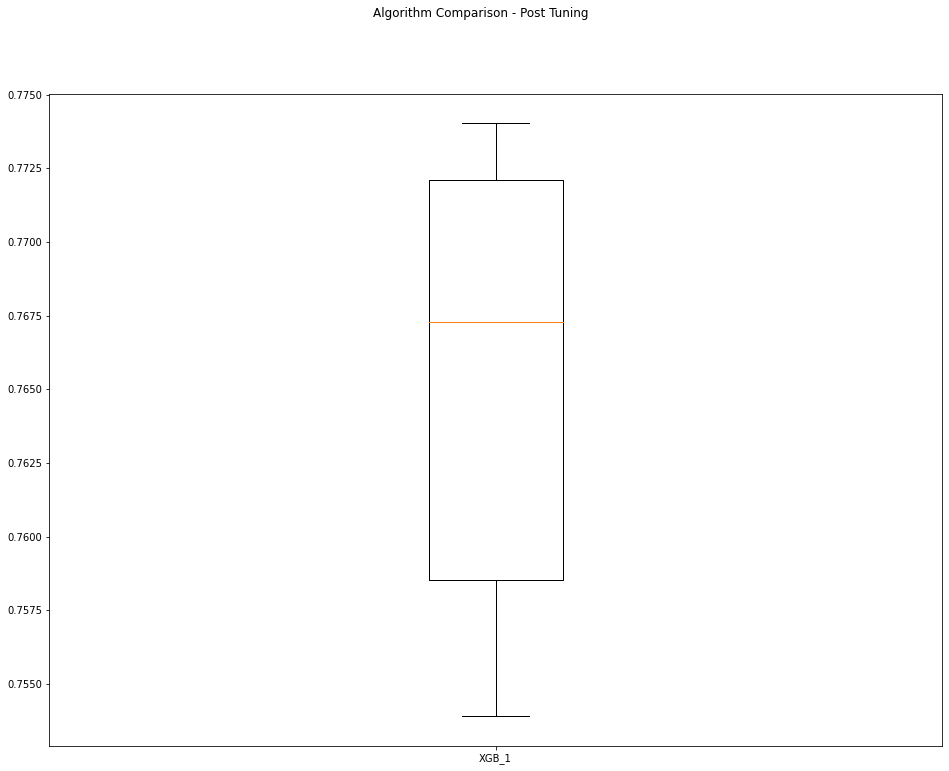

In [45]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_model_names)
plt.show()

## Task 6. Finalize Model

In [0]:
if notifyStatus: email_notify("Model Validation and Final Model Creation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Measure predictions from the test dataset

In [47]:
test_model = XGBClassifier(n_estimators=2000, max_depth=12, random_state=seedNum, n_jobs=n_jobs, objective='binary:logistic', tree_method='gpu_hist')
test_model.fit(X_train, y_train)
predictions1 = test_model.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test, predictions1))
print('ROC/AUC Score:', roc_auc_score(y_test, predictions1))
print(confusion_matrix(y_test, predictions1))
print(classification_report(y_test, predictions1))
print(test_model)

Accuracy Score: 0.632766
ROC/AUC Score: 0.6389046870224683
[[175370  60123]
 [123494 141013]]
              precision    recall  f1-score   support

           0       0.59      0.74      0.66    235493
           1       0.70      0.53      0.61    264507

    accuracy                           0.63    500000
   macro avg       0.64      0.64      0.63    500000
weighted avg       0.65      0.63      0.63    500000

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=None, n_estimators=2000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=888,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)


### 6.b) Create a standalone model using all available data

In [0]:
# Combining the training and testing datasets to form the complete dataset that will be used for training the final model
# X_complete = np.vstack((X_train, X_test))
# y_complete = np.concatenate((y_train, y_test))
# print("X_complete.shape: {} y_complete.shape: {}".format(X_complete.shape, y_complete.shape))
# final_model = test_model1.fit(X_complete, y_complete)
# print(final_model)

### 6.c) Save the final model for later use

In [0]:
# modelName = 'FinalModel_BinaryClass.sav'
# dump(final_model, modelName)

In [0]:
if notifyStatus: email_notify("Model Validation and Final Model Creation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [51]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 11:19:52.663370
